In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

In [29]:
df_month_data = pd.read_csv("Cst_to_U.csv",index_col=False,encoding="utf-8")
alpha = 0.9
destination = 'Uppsala c'

In [30]:
def create_adjacency_matrix(df, destination_station=None):
    """
    Create an adjacency matrix from travel records
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing travel records
    destination_station (str, optional): Final destination station to exclude
    
    Returns:
    pandas.DataFrame: Adjacency matrix of stations
    """
    # Extract all stations except the destination station
    all_departure_stations = set(df['Avgångsplats'])
    all_arrival_stations = set(df['Ankomstplats'])
    
    # Combine all stations and remove destination station if specified
    all_stations = list(all_departure_stations.union(all_arrival_stations))
    if destination_station in all_stations:
        all_stations.remove(destination_station)
    
    # Sort station names for consistent ordering
    all_stations.sort()
    
    # Create empty adjacency matrix
    n = len(all_stations)
    adj_matrix = pd.DataFrame(np.zeros((n, n), dtype=int),
                              index=all_stations, columns=all_stations)
    
    # Fill adjacency matrix
    for _, row in df.iterrows():
        dep_station = row['Avgångsplats']
        arr_station = row['Ankomstplats']
        
        # Skip connections involving the destination station
        if dep_station == destination_station or arr_station == destination_station:
            continue
        
        # Mark connection between departure and arrival stations
        if dep_station in all_stations and arr_station in all_stations:
            adj_matrix.loc[dep_station, arr_station] = 1
    
    return adj_matrix,all_stations

In [31]:
def plot_adjacency_matrix(adj_matrix, station_names):
    """
    Plot the adjacency matrix using seaborn heatmap.
    
    Parameters:
    adj_matrix (numpy.ndarray): The adjacency matrix
    station_names (list): List of station names
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(adj_matrix, cmap='Blues', 
                xticklabels=station_names, 
                yticklabels=station_names,
                linewidths=0.5,
                linecolor='lightgray')
    plt.title('Station Connectivity Adjacency Matrix')
    plt.xlabel('To Station')
    plt.ylabel('From Station')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

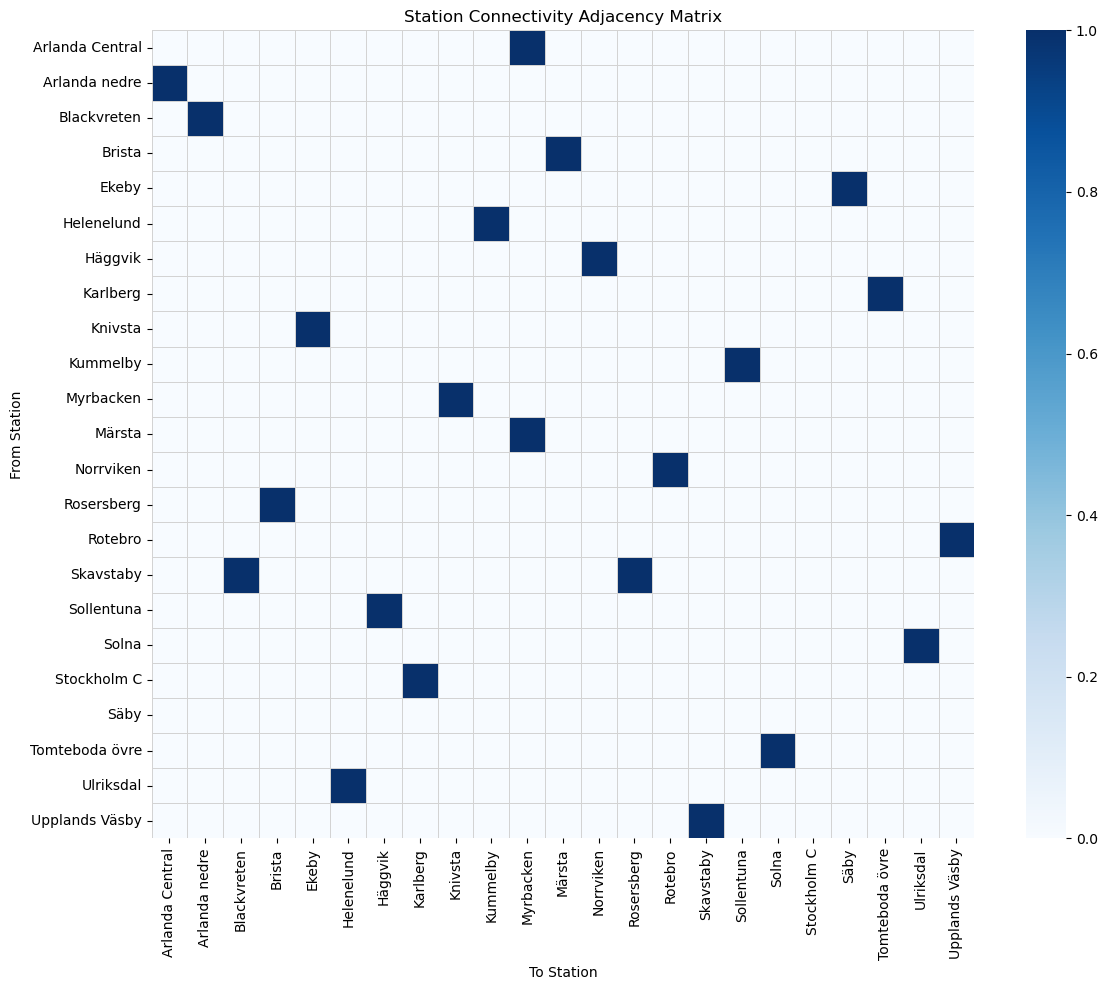

In [32]:
adj_max, all_stations = create_adjacency_matrix(df_month_data,destination)
plot_adjacency_matrix(adj_max, all_stations)

In [44]:
def create_delay_adjacency_matrix(df, adjacency_matrix, destination_station):
    """
    Create a delay adjacency matrix and vector based on an existing adjacency matrix
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing travel records with 'AvgFörsening' column
    adjacency_matrix (pandas.DataFrame): Existing adjacency matrix showing connected stations
    destination_station (str): Final destination station
    
    Returns:
    tuple: (delay_matrix, delay_vector)
        - delay_matrix: pandas.DataFrame with average delays between adjacent stations
        - delay_vector: pandas.Series with average delays between stations and destination
    """
    # Get the list of stations (excluding destination)
    stations = adjacency_matrix.index.tolist()
    
    # Create empty delay matrix with same dimensions as adjacency matrix
    delay_matrix = pd.DataFrame(np.zeros(adjacency_matrix.shape),
                               index=stations, columns=stations)
    
    # Create delay vector for connections to destination
    delay_vector = pd.Series(np.zeros(len(stations)), index=stations)
    
    # Fill delay matrix for adjacent stations
    for i, stationi in enumerate(stations):
        for j, stationj in enumerate(stations):
            # Check if stations are adjacent according to adjacency matrix
            if adjacency_matrix.loc[stationi, stationj] == 1:
                # Get records for travels between these stations
                station_travels = df[(df['Avgångsplats'] == stationi) & 
                                    (df['Ankomstplats'] == stationj)]
                
                if not station_travels.empty:
                    # Calculate average delay for this connection
                    df_filtered_travels = station_travels[station_travels['AvgFörsening'] > alpha]
                    # df_filtered_travels['AvgFörsening'] = df_filtered_travels['AvgFörsening'].apply(lambda x: max(0, x))
                    avg_delay = df_filtered_travels['AvgFörsening'].mean()
                    delay_matrix.loc[stationi, stationj] = avg_delay
    
    # Fill delay vector for connections to destination
    for station in stations:
        # Get records for travels between station and destination
        destination_travels = df[(df['Avgångsplats'] == station) & 
                                (df['Ankomstplats'] == destination_station)]
        
        if not destination_travels.empty:
            # Calculate average delay for this connection to destination
            df_filtered_travels = destination_travels[destination_travels['AvgFörsening'] > alpha]
            avg_delay = df_filtered_travels['AvgFörsening'].mean()
            delay_vector[station] = avg_delay
    
    return delay_matrix, delay_vector

In [45]:
def plot_combined_delay_analysis(delay_matrix, delay_vector, destination_station, figsize=(16, 12)):
    """
    Create a combined visualization with both delay matrix and vector
    
    Parameters:
    delay_matrix (pandas.DataFrame): Matrix containing average delays between stations
    delay_vector (pandas.Series): Vector containing average delays to destination
    destination_station (str): Name of the destination station
    figsize (tuple): Figure size as (width, height)
    
    Returns:
    matplotlib.figure.Figure: The figure object containing the plots
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [2, 1]})
    
    # Plot the delay matrix on the first subplot
    plt.sca(ax1)
    plot_matrix = delay_matrix.copy().replace(0, np.nan)
    sns.heatmap(plot_matrix, 
                cmap=sns.color_palette("YlOrRd", as_cmap=True),
                annot=True,
                fmt=".1f",
                linewidths=0.5,
                square=True,
                mask=plot_matrix.isna(),
                cbar_kws={'label': 'Average Delay (minutes)'})
    plt.title(f'Delay Matrix Between Stations', fontsize=16, pad=20)
    plt.xlabel('Arrival Station', fontsize=12, labelpad=10)
    plt.ylabel('Departure Station', fontsize=12, labelpad=10)
    plt.xticks(rotation=45, ha='right')
    
    # Plot the delay vector on the second subplot
    plt.sca(ax2)
    plot_vector = delay_vector[delay_vector > 0].sort_values(ascending=False)
    colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(plot_vector)))
    ax2.barh(plot_vector.index, plot_vector.values, color=colors)
    
    # Add value labels
    for i, v in enumerate(plot_vector.values):
        ax2.text(v + 0.1, i, f'{v:.1f}', va='center')
    
    plt.title(f'Average Delays to {destination_station}', fontsize=16, pad=20)
    plt.xlabel('Average Delay (minutes)', fontsize=12)
    plt.ylabel('Departure Station', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

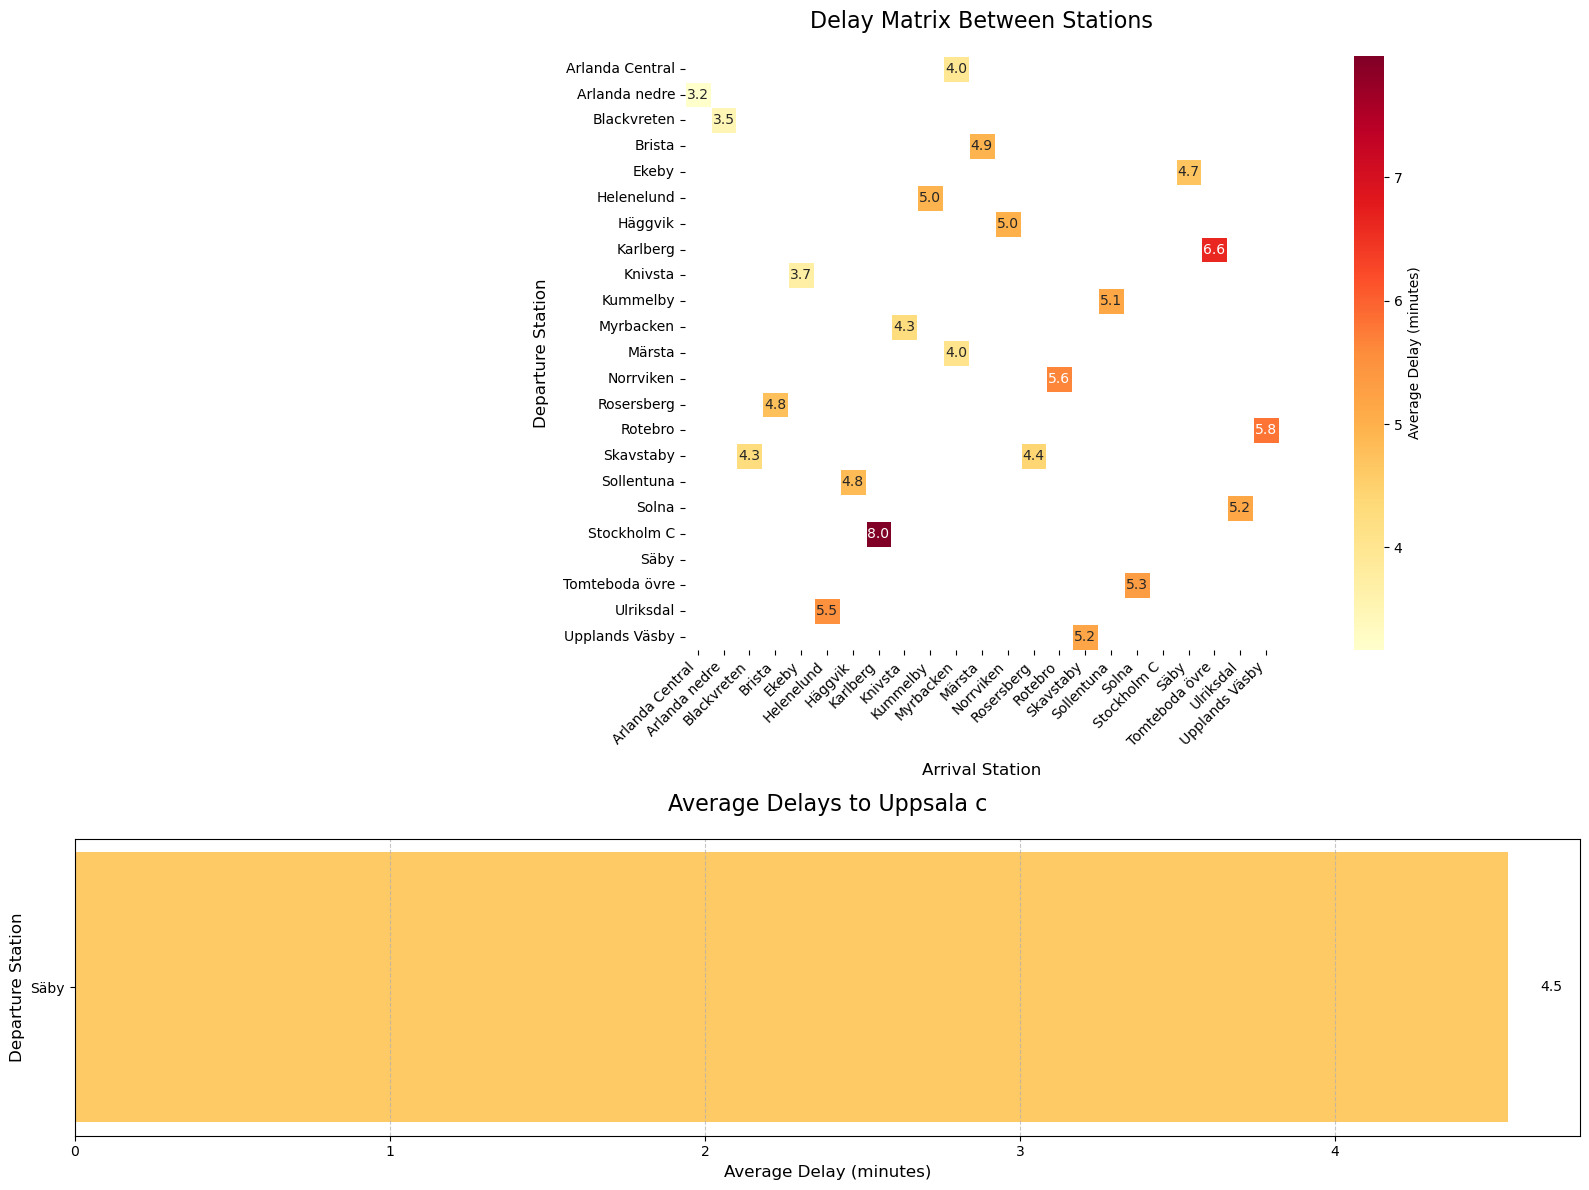

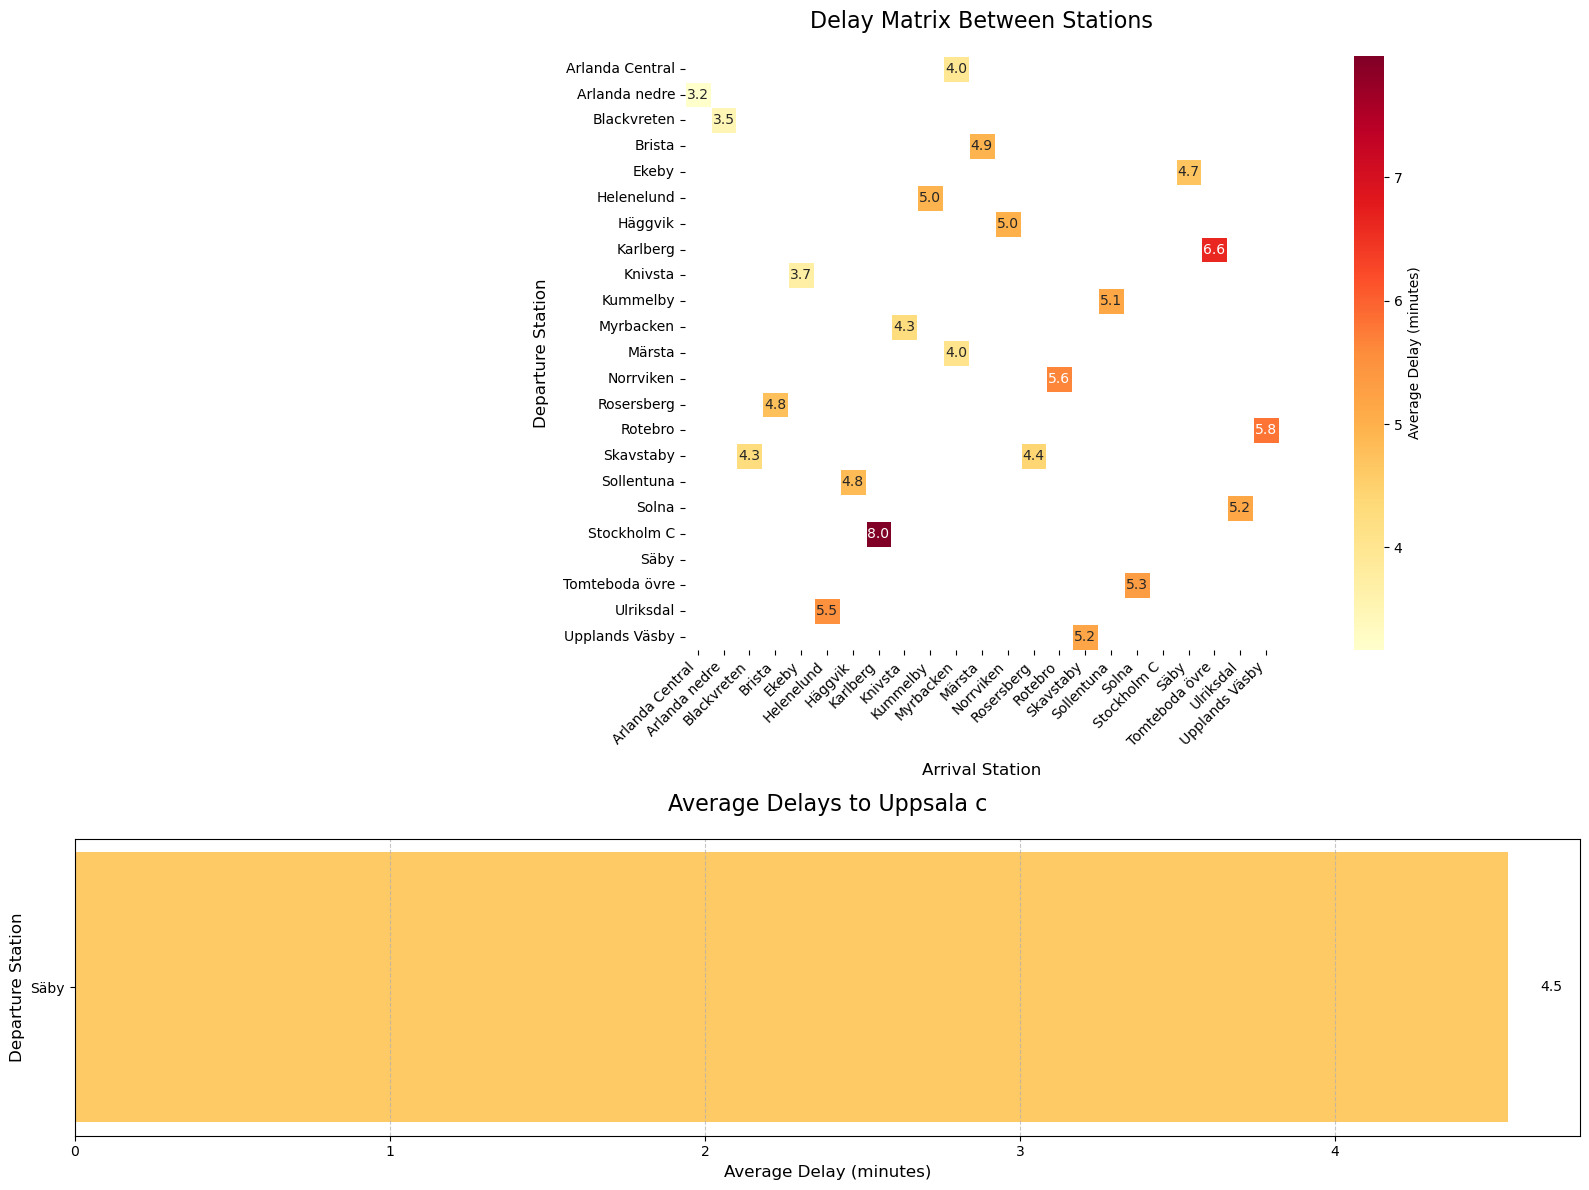

In [46]:
delayed_adjacent_matrix, delayed_vector = create_delay_adjacency_matrix(df_month_data, adj_max, destination)
plot_combined_delay_analysis(delayed_adjacent_matrix, delayed_vector, destination)

In [47]:
all_delayed_adj_matrix = np.concatenate([delayed_adjacent_matrix.to_numpy(), 
                              delayed_vector.to_numpy().reshape(-1, 1)], axis=1)
infinity_vect = np.full((len(all_stations)+1,1),np.inf)
cost_matrix = np.concatenate([all_delayed_adj_matrix, infinity_vect.reshape(1, -1)], axis=0)

In [48]:
def randomized_shortest_path(cost_matrix, source, destination, theta=1.0):
    """
    Compute the optimal randomized shortest path policy using Akamatsu's model.
    
    Args:
        cost_matrix: n x n matrix of immediate costs between nodes
        source: index of the source node (0-based)
        destination: index of the destination node (0-based)
        theta: parameter controlling the degree of exploration (higher = more exploration)
        
    Returns:
        Transition probability matrix P
    """
    n = cost_matrix.shape[0]
    
    # Step 1: Compute W matrix (elementwise exponential of -theta * cost_matrix)
    W = np.exp(-theta * cost_matrix)
    
    # Step 2: Check spectral radius condition (simplified check)
    # In practice, for large matrices, computing spectral radius is expensive
    # So we'll just proceed and handle numerical issues if they arise
    
    # Step 5: Solve (I - W)z_n = e_n for z_n
    I = np.eye(n)
    e_n = np.zeros(n)
    e_n[destination] = 1
    
    # Using sparse solver if matrix is large
    if n > 1000:
        W_sparse = csr_matrix(W)
        I_sparse = csr_matrix(I)
        A = I_sparse - W_sparse
        z_n = spsolve(A, e_n)
    else:
        z_n = np.linalg.solve(I - W, e_n)
    
    # Step 6: Compute transition probabilities
    P = np.zeros((n, n))
    
    for k in range(n):
        if k == destination:
            # Absorbing state - stay with probability 1
            P[k, k] = 1.0
        else:
            # Get successors (nodes with finite cost)
            successors = np.where(cost_matrix[k, :] < np.inf)[0]
            
            # Compute denominator sum
            denom = 0.0
            for k_prime in successors:
                denom += z_n[k_prime] * np.exp(-theta * cost_matrix[k, k_prime])
            
            # Compute probabilities
            for k_prime in successors:
                if denom > 0:
                    P[k, k_prime] = (z_n[k_prime] / z_n[k]) * np.exp(-theta * cost_matrix[k, k_prime])
                else:
                    # Handle case where denominator is 0 (shouldn't happen for valid inputs)
                    P[k, k_prime] = 1.0 / len(successors) if len(successors) > 0 else 0
            
            # Normalize to ensure probabilities sum to 1 (handles numerical precision issues)
            row_sum = np.sum(P[k, :])
            if row_sum > 0:
                P[k, :] /= row_sum
    
    return P

In [38]:
result = randomized_shortest_path(cost_matrix, 19, 23)
# result[0,10]
pd.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,...,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
1,-0.048109,1.000000,-1.066199,1.041197,1.111969,-2.084627,2.030243,-2.051996,-1.181716,2.001757,...,2.052003,2.070055,-2.111077,-2.064699,1.954264,-1.220162,1.957517,1.979115,-2.155458,1.135129
2,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,...,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
3,-1.099831,0.960433,-1.024012,1.000000,1.067971,-2.002144,1.949912,-1.970804,-1.134959,1.922553,...,1.970811,1.988149,-2.027547,-1.983004,1.876939,-1.171884,1.880064,1.900807,-2.070173,1.090215
4,-1.029832,0.899306,-0.958839,0.936355,1.000000,-1.874717,1.825809,-1.845371,-1.062724,1.800191,...,1.845378,1.861612,-1.898503,-1.856795,1.757481,-0.010038,1.760406,1.779829,-1.938416,1.020828
5,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,...,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
6,-0.564041,0.492552,-0.525158,0.512844,0.547702,-1.026787,1.000000,-1.010714,-0.582057,0.985969,...,1.010718,1.019609,-1.039815,-1.016971,0.962576,-0.600993,0.964179,0.974817,-1.061675,0.559110
7,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,...,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
8,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,...,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
9,-0.572068,0.499561,-0.532632,0.520142,0.555497,-1.041399,1.014231,-1.025097,-0.590340,1.000000,...,1.025101,1.034119,-0.006139,-1.031443,0.976274,-0.609546,0.977900,0.988689,-1.076783,0.567066


In [39]:
# To Do:
    # Check averate dealy is negavie, they need to be set to 0
    # Sort stations.